In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the time series dataset
data = pd.read_csv('../datasets/complete_data/df.csv')

# Change column names to match naming convention
data = data.rename(columns={'start MTU (UTC)': 'ds', 'Day-ahead Price [EUR/MWh] BZN|NO1': 'y'})

# Convert the 'ds' column to datetime type
data['ds'] = pd.to_datetime(data['ds'])

In [3]:
# Extract the year, month, day and hour from the 'ds' column
data['month'] = data['ds'].dt.month
data['day'] = data['ds'].dt.day
data['hour'] = data['ds'].dt.hour
data['weekday'] = data['ds'].dt.weekday

# Technical indicators
# Moving average deviation
data['MAD'] = data['y'].rolling(window=24).mean() - data['y']
# Percentage range
data['PR'] = (data['y'].rolling(window=24).max() - data['y'].rolling(window=24).min()) / data['y'].rolling(window=24).mean()
# Percentage price change moving average
data['PPCMA'] = data['y'].rolling(window=24).mean().pct_change()

In [4]:
# Set the 'ds' column as the index of the dataframe
data.set_index('ds', inplace=True)

# Print number of rows and columns
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 8760
Number of columns: 43


In [5]:
# Split the dataset into training, validation and testing sets
train, test = train_test_split(data, test_size=0.1, shuffle=False)

In [6]:
# Lagged features
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df['y'] = lagged_df['y'].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(24)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

In [7]:
# Create lagged training and testing sets
lagged_train = create_lagged_dataset(train)
lagged_test = create_lagged_dataset(test)

In [8]:
# Split the training and testing sets into X_train , y_train , X_test , and y_test
X_train = lagged_train.drop(['y'], axis=1)
y_train = lagged_train['y']

X_test = lagged_test.drop(['y'], axis=1)
y_test = lagged_test['y']

# Print the shape of the training, validation and testing datasets
print("Training set shape:  ", X_train.shape, y_train.shape)
print("Testing set shape:   ", X_test.shape, y_test.shape)

Training set shape:   (7836, 1008) (7836, 24)
Testing set shape:    (852, 1008) (852, 24)


In [9]:
# Scaling the data with standard scaler
Sc = StandardScaler()

cols = X_train.columns
# Fitting scaler to training data and transforming
X_train = Sc.fit_transform(X_train)
# Transforming testing data
X_test = Sc.transform(X_test)

## Linear Regression

In [10]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train, y_train)

LinearRegression()

In [11]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_test = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_test)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_test)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_test)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.9299821368274828
Mean absolute percentage error:  7.665156550727505 %
Mean squared error:              11.768461373311126
Root mean squared error:         3.4305191113461424

Scores on testing set
Mean absolute error:             3.8877779345810914
Mean absolute percentage error:  1.919498164606928 %
Mean squared error:              30.33589639390645
Root mean squared error:         5.5078032275950495


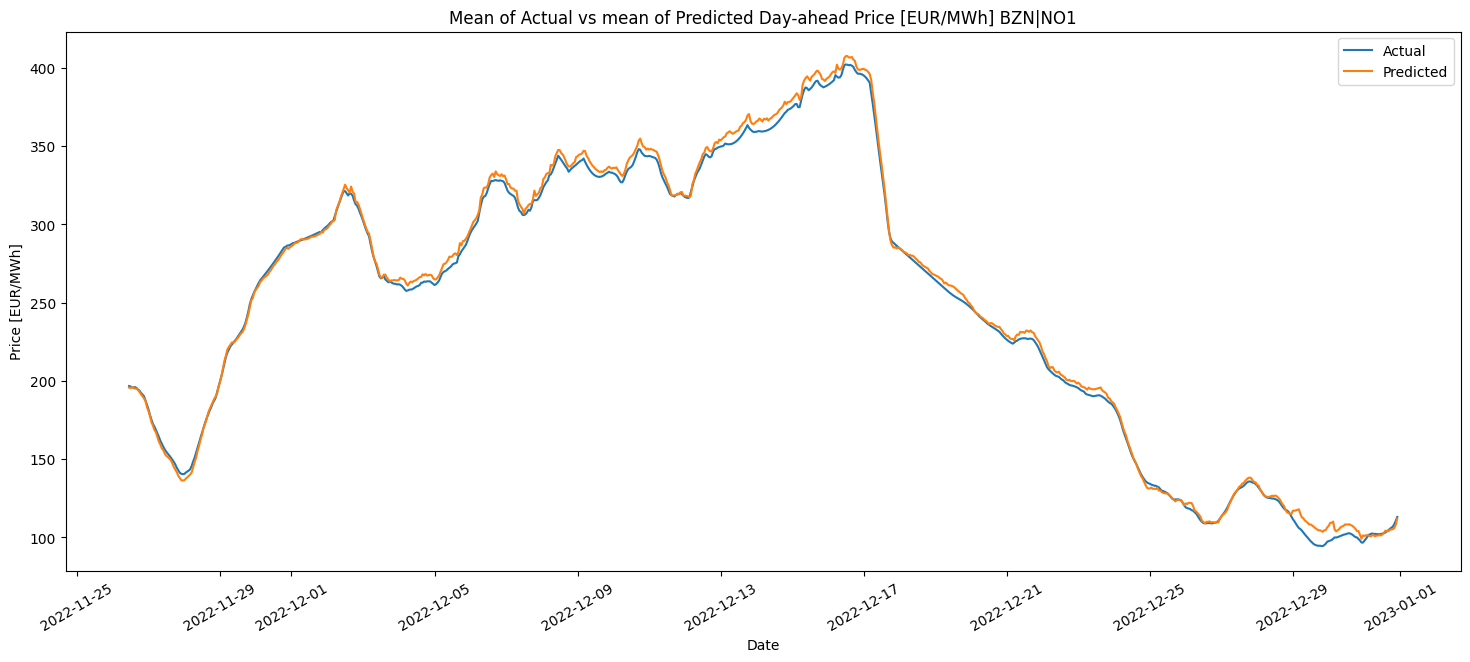

In [12]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_test, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Lasso Regression

In [13]:
params = {
    'alpha': [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'max_iter': [100000]
}

lasso = Lasso()

lasso_regressor = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)

{'alpha': 0.1, 'max_iter': 100000}


In [14]:
# Create a Lasso Regression model with the optimal hyperparameters
model = lasso_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=100000)

In [15]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.8701330370354057
Mean absolute percentage error:  5.569271240313615 %
Mean squared error:              16.07989316573945
Root mean squared error:         4.009974210109019

Scores on testing set
Mean absolute error:             2.6956504689172767
Mean absolute percentage error:  1.5303507390902396 %
Mean squared error:              21.745468826034045
Root mean squared error:         4.663203708399843


### Feature selection with Lasso Regression

In [16]:
# Create a pipeline with feature selection
pipeline = Pipeline([('select', SelectFromModel(Lasso())), ('lasso', Lasso())])

# Define a range of threshold values to test
thresholds = np.arange(0.1, 1.0, 0.1)

# Create a grid search to find the best threshold value
grid_search = GridSearchCV(pipeline, {'select__threshold': thresholds}, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best threshold value
print("Best threshold: {:.2f}".format(grid_search.best_params_['select__threshold']))

Best threshold: 0.90


In [17]:
# Print shapes of X_train and X_test before transformation
print("X_train.shape before feature selection: {}".format(X_train.shape))
print("X_test.shape before feature selection: {}".format(X_test.shape))

# Print the selected features
selected_features = cols[grid_search.best_estimator_.named_steps['select'].get_support()]
print("Selected features: {}".format(selected_features))

# Change X_train and test to only contain the selected features
X_train_selected = grid_search.best_estimator_.named_steps['select'].transform(X_train)
X_test_selected = grid_search.best_estimator_.named_steps['select'].transform(X_test)

# Print shape of X_train and X_test
print("X_train.shape after feature selection: {}".format(X_train_selected.shape))
print("X_test.shape after feature selection: {}".format(X_test_selected.shape))

X_train.shape before feature selection: (7836, 1008)
X_test.shape before feature selection: (852, 1008)
Selected features: Index(['Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|SE3', 'MAD',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] 

### Lasso Regression with selected features

In [18]:
params = {
    'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'max_iter': [100000]
}

lasso = Lasso()

lasso_regressor = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train_selected, y_train)

print(lasso_regressor.best_params_)

{'alpha': 0.001, 'max_iter': 100000}


In [19]:
# Create a Lasso Regression model with the optimal hyperparameters
model = lasso_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train_selected, y_train)

Lasso(alpha=0.001, max_iter=100000)

In [20]:
# Make a prediction on the training set
predicted_train = model.predict(X_train_selected)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test_selected)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.6708536874090438
Mean absolute percentage error:  1.4807134021249309 %
Mean squared error:              32.83670607439259
Root mean squared error:         5.730332108559903

Scores on testing set
Mean absolute error:             2.447261685429423
Mean absolute percentage error:  1.6296744302347577 %
Mean squared error:              29.287376008010302
Root mean squared error:         5.411781223221269


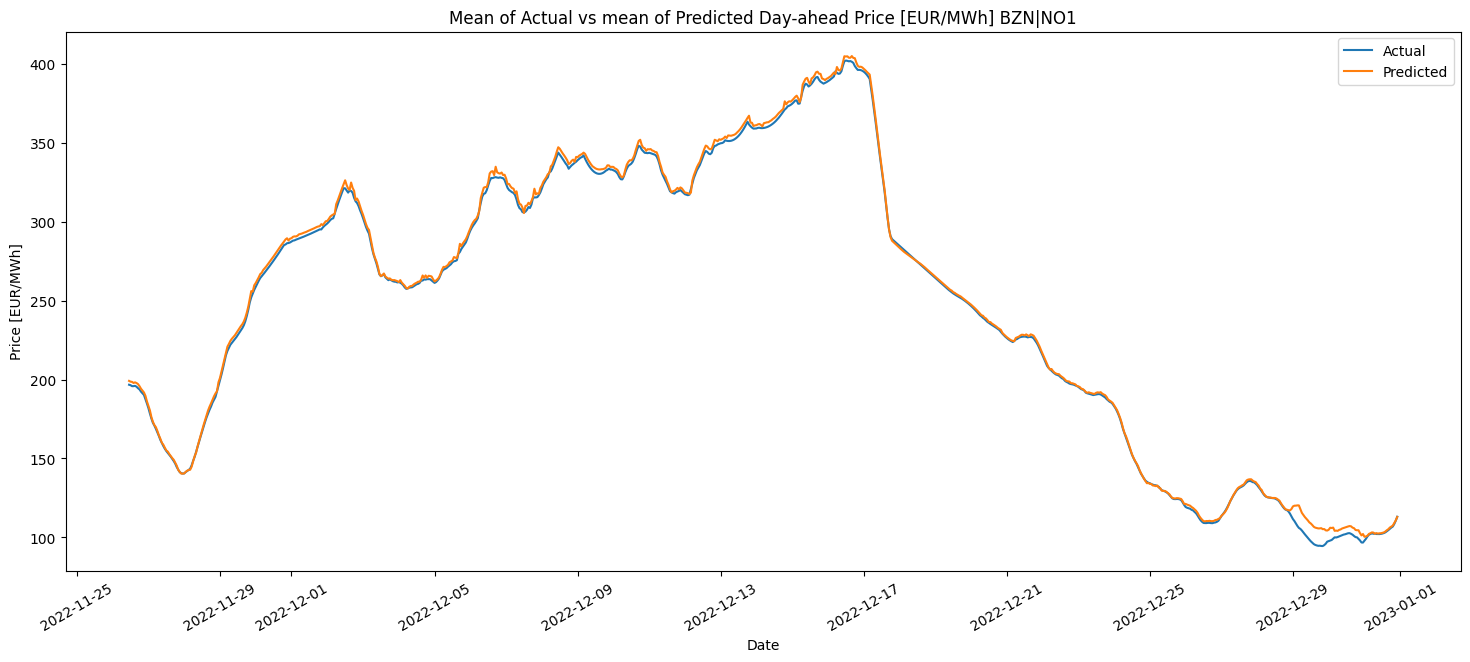

In [21]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Linear Regression with selected features from lasso

In [22]:
# Create new model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train_selected, y_train)

LinearRegression()

In [23]:
# Make a prediction on the training set
predicted_train = model.predict(X_train_selected)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test_selected)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.6745873518745398
Mean absolute percentage error:  1.4848801824144109 %
Mean squared error:              32.83399532264565
Root mean squared error:         5.730095577095172

Scores on testing set
Mean absolute error:             2.4535141232506343
Mean absolute percentage error:  1.6325841250963358 %
Mean squared error:              29.303035773789862
Root mean squared error:         5.413227851641741


## Ridge Regression

In [24]:
params = {
    'alpha': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.1, 1.5,  2, 10, 20, 50, 100, 1000]
}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train_selected, y_train)

print(ridge_regressor.best_params_)

{'alpha': 0.01}


In [25]:
# Create a Ridge Regression model with the optimal hyperparameters
model = ridge_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train_selected, y_train)

Ridge(alpha=0.01)

In [26]:
# Make a prediction on the training set
predicted_train = model.predict(X_train_selected)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test_selected)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.6745844141433661
Mean absolute percentage error:  1.4848724005676008 %
Mean squared error:              32.83399985757745
Root mean squared error:         5.730095972806865

Scores on testing set
Mean absolute error:             2.4534535399569024
Mean absolute percentage error:  1.632568517314766 %
Mean squared error:              29.30287444096685
Root mean squared error:         5.413212949900165


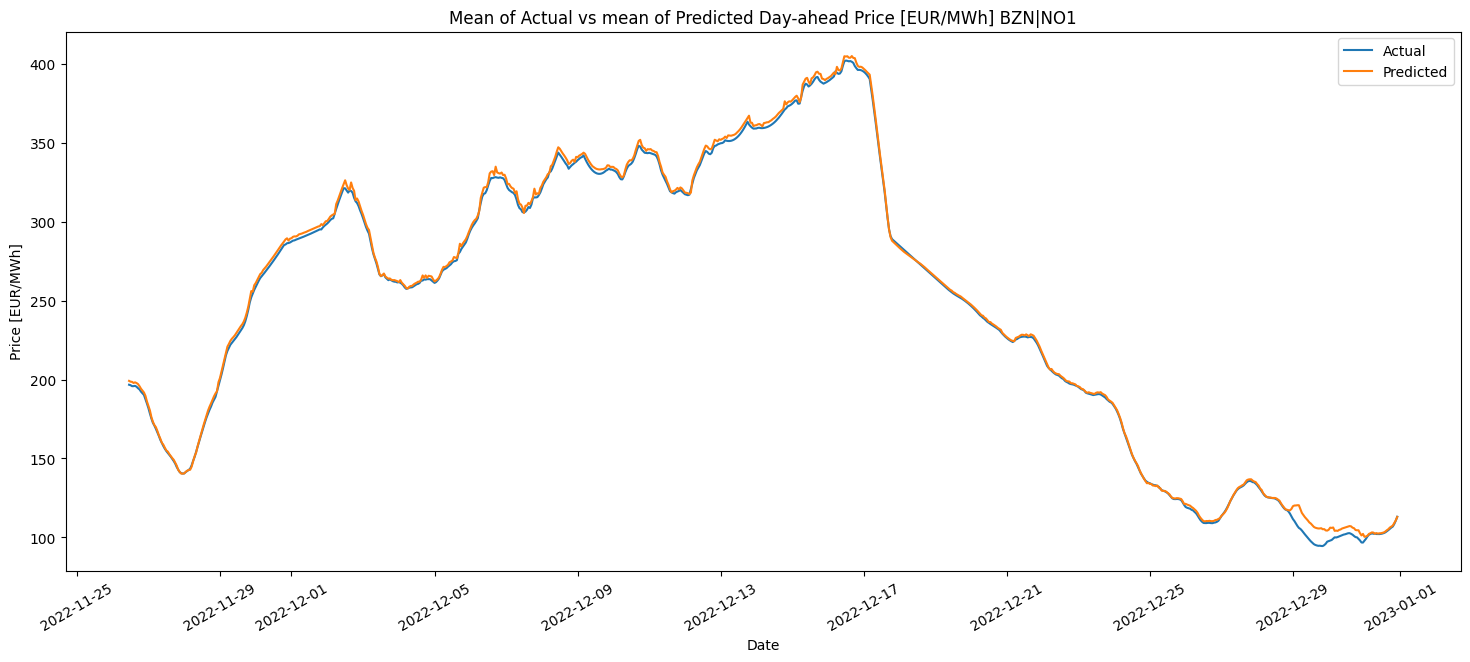

In [27]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Elastic Net Regression

In [28]:
# Create an Elastic Net Regression model with the optimal hyperparameters
model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=100000)

# Fit the model to the training set
model.fit(X_train, y_train)

ElasticNet(alpha=0.01, max_iter=100000)

In [29]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.956078996474928
Mean absolute percentage error:  7.932423941041726 %
Mean squared error:              12.58637442393912
Root mean squared error:         3.5477280651057685

Scores on testing set
Mean absolute error:             3.5646176685722373
Mean absolute percentage error:  1.8150180714099091 %
Mean squared error:              27.31957639435389
Root mean squared error:         5.22681321594276


### Feature selection with elasticNet

In [30]:
# Create a pipeline with feature selection
pipeline = Pipeline([('select', SelectFromModel(ElasticNet(max_iter=100000))), ('elastic_net', ElasticNet(max_iter=100000))])

# Define a range of threshold values to test
thresholds = np.arange(0.1, 1.0, 0.1)

# Create a grid search to find the best threshold value
grid_search = GridSearchCV(pipeline, {'select__threshold': thresholds}, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best threshold value
print("Best threshold: {:.2f}".format(grid_search.best_params_['select__threshold']))

Best threshold: 0.90


In [31]:
# Print shapes of X_train and X_test before transformation
print("X_train.shape before feature selection: {}".format(X_train.shape))
print("X_test.shape before feature selection: {}".format(X_test.shape))

# Print the selected features
selected_features = cols[grid_search.best_estimator_.named_steps['select'].get_support()]
print("Selected features: {}".format(selected_features))

# Change X_train and test to only contain the selected features
X_train_selected_e = grid_search.best_estimator_.named_steps['select'].transform(X_train)
X_test_selected_e = grid_search.best_estimator_.named_steps['select'].transform(X_test)

# Print shape of X_train and X_test
print("X_train.shape after feature selection: {}".format(X_train_selected_e.shape))
print("X_test.shape after feature selection: {}".format(X_test_selected_e.shape))

X_train.shape before feature selection: (7836, 1008)
X_test.shape before feature selection: (852, 1008)
Selected features: Index(['Day-ahead Price [EUR/MWh] BZN|NO5',
       'Day-ahead Price [EUR/MWh] BZN|SE3', 'Actual Total Load [MW] - BZN|NO5',
       'Hydro Run-of-river and poundage - BZN|NO1',
       'Hydro Water Reservoir - BZN|NO1',
       'Hydro Run-of-river and poundage - BZN|NO2',
       'Hydro Water Reservoir - BZN|NO2', 'Waste - BZN|NO2',
       'Other renewable - BZN|NO3',
       'Hydro Run-of-river and poundage - BZN|NO5',
       ...
       'Actual Total Load [MW] - BZN|NO5',
       'Hydro Run-of-river and poundage - BZN|NO1',
       'Hydro Run-of-river and poundage - BZN|NO2', 'Waste - BZN|NO2',
       'Other renewable - BZN|NO3',
       'Hydro Run-of-river and poundage - BZN|NO5',
       'CBF BZN|NO1 > BZN|NO2 [MW]', 'CBF BZN|NO1 > BZN|SE3 [MW]', 'MAD',
       'PR'],
      dtype='object', length=276)
X_train.shape after feature selection: (7836, 276)
X_test.shape after f

In [32]:
# Create an Elastic Net Regression model with the optimal hyperparameters
params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.1, 10],
    'l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.9, 1],
    'max_iter': [100000]
}

elastic_net = ElasticNet()

elastic_net_regressor = GridSearchCV(elastic_net, params, scoring='neg_mean_squared_error', cv=5)

elastic_net_regressor.fit(X_train_selected_e, y_train)

print(elastic_net_regressor.best_params_)

{'alpha': 0.01, 'l1_ratio': 0.9, 'max_iter': 100000}


In [33]:
# Create model with optimal hyperparameters
model = elastic_net_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train_selected_e, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=100000)

In [34]:
# Make a prediction on the training set
predicted_train = model.predict(X_train_selected_e)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test_selected_e)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.9481261472152076
Mean absolute percentage error:  8.258461819713451 %
Mean squared error:              14.579745158817369
Root mean squared error:         3.818343247904432

Scores on testing set
Mean absolute error:             3.482476213229114
Mean absolute percentage error:  1.8746896833953548 %
Mean squared error:              26.584988289597224
Root mean squared error:         5.1560632550034935


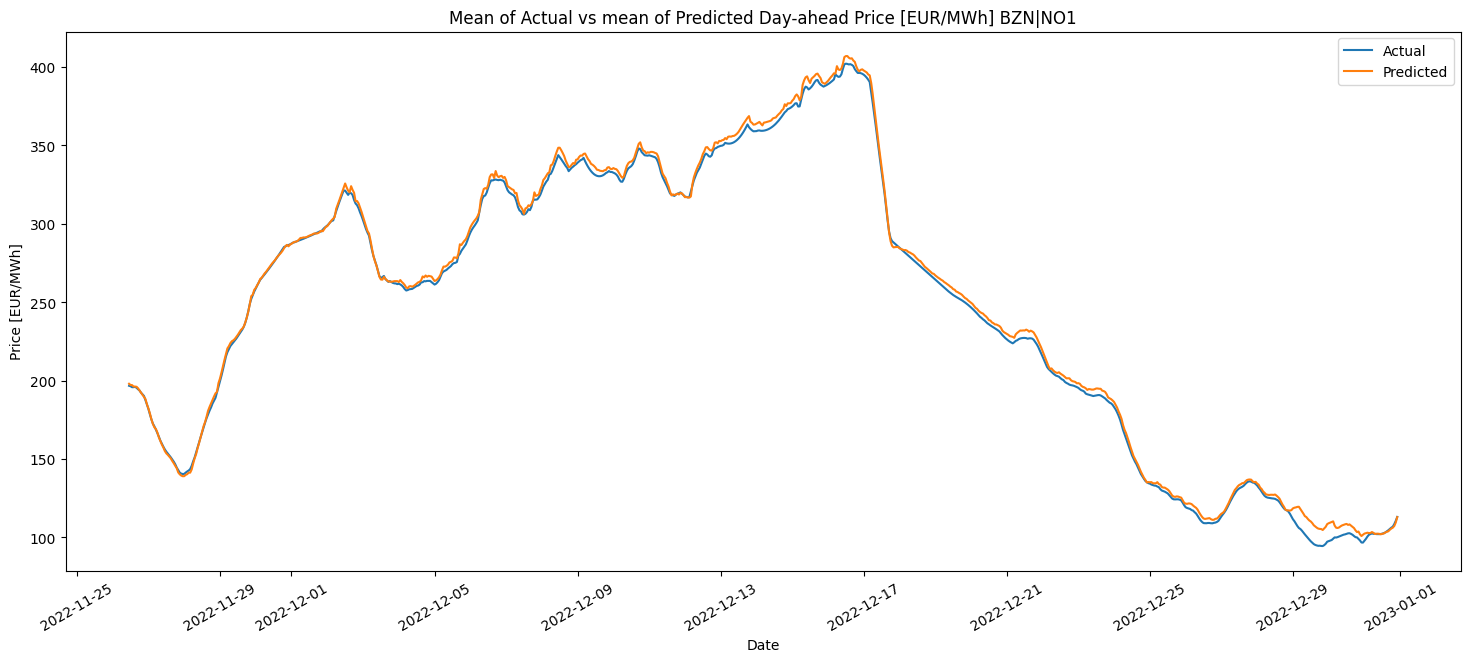

In [35]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Linear regression with selected features from elasticNet

In [36]:
# Create model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train_selected_e, y_train)

LinearRegression()

In [37]:
# Make a prediction on the training set
predicted_train = model.predict(X_train_selected_e)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test_selected_e)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             1.9771158070453003
Mean absolute percentage error:  8.822827422245323 %
Mean squared error:              14.291646477630586
Root mean squared error:         3.780429403868109

Scores on testing set
Mean absolute error:             3.5895378469744865
Mean absolute percentage error:  1.910389944097164 %
Mean squared error:              27.694051356855294
Root mean squared error:         5.262513786856553
